# Notebook to interpret the results of modkmeans_extract.py

In [20]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

## Load data

In [4]:
# Parameters
max_k_clusters = 50
n_subjects = 50

In [29]:

input_path = os.path.abspath('../Output/ica_rest_all')

models_path = f'find_{max_k_clusters}_clusters'

modkmeans_path = os.path.abspath(os.path.join(input_path, 'modkmeans_results', 'models', models_path))
if not os.path.exists(modkmeans_path):
    os.makedirs(modkmeans_path)
results = {}
for i in range(n_subjects):
    id_name = f'{i:03d}'
    results_path = os.path.join(input_path, modkmeans_path,f'modkmeans_s{id_name}.npy')
    if os.path.exists(results_path):
        print(f"Loading results for subject {id_name}")
        result = np.load(results_path, allow_pickle=True).item()
        results[id_name] = result


Loading results for subject 000
Loading results for subject 001
Loading results for subject 002
Loading results for subject 003
Loading results for subject 004
Loading results for subject 005
Loading results for subject 006
Loading results for subject 007
Loading results for subject 008
Loading results for subject 009
Loading results for subject 010
Loading results for subject 011
Loading results for subject 012
Loading results for subject 013
Loading results for subject 014
Loading results for subject 015
Loading results for subject 016
Loading results for subject 017
Loading results for subject 018
Loading results for subject 019
Loading results for subject 020
Loading results for subject 021
Loading results for subject 022
Loading results for subject 023
Loading results for subject 024
Loading results for subject 025
Loading results for subject 026
Loading results for subject 027
Loading results for subject 028
Loading results for subject 029
Loading results for subject 030
Loading 

## Processing results
### Normalizing min-max results


In [22]:
def normalize_clustering_metrics(data_dict):
    """
    Normalize clustering evaluation metrics for each subject separately.
    Only normalizes metrics that need it - keeps GEV and Spatial_correlation as-is.
    
    Parameters:
    data_dict: Dictionary with subject IDs as keys, containing 'cluster_number' and 'scores'
    
    Returns:
    normalized_data: Dictionary with same structure but normalized scores
    """
    
    # Metrics that should NOT be normalized (already 0-1)
    SKIP_NORMALIZATION = {'GEV', 'Spatial_correlation'}
    
    # Metrics that need normalization
    NORMALIZE_METRICS = {'Calinski-Harabasz', 'Calinski-Harabasaz', 'Davies-Bouldin', 'Inv-Davies-Bouldin'}
    
    normalized_data = {}
    
    for subject_id, subject_data in data_dict.items():
        print(f"Processing subject {subject_id}...")
        
        # Copy the structure
        normalized_data[subject_id] = {
            'cluster_number': subject_data['cluster_number'],
            'scores': {}
        }
        
        scores = subject_data['scores']
        
        for metric_name, values in scores.items():
            # Handle naming correction
            if metric_name == 'Calinski-Harabasaz':
                clean_metric_name = 'Calinski-Harabasz'
            else:
                clean_metric_name = metric_name
            
            values_array = np.array(values)
            
            # Check if this metric should be normalized
            if clean_metric_name in SKIP_NORMALIZATION:
                # Keep original values for GEV and Spatial_correlation
                normalized_data[subject_id]['scores'][clean_metric_name] = values
                print(f"  {clean_metric_name} - KEPT ORIGINAL (already 0-1): {values_array.min():.3f} to {values_array.max():.3f}")
                continue
            
            # Apply normalization to other metrics
            print(f"  {clean_metric_name} - Original range: {values_array.min():.2e} to {values_array.max():.2e}")
            
            # Handle problematic values in Davies-Bouldin
            if 'Davies-Bouldin' in metric_name:
                # Cap extreme values (recommended)
                percentile_99 = np.percentile(values_array, 99)
                values_capped = np.clip(values_array, None, percentile_99)
                print(f"  {clean_metric_name} - After capping at 99th percentile: {values_capped.min():.2e} to {values_capped.max():.2e}")
                values_to_normalize = values_capped
            else:
                values_to_normalize = values_array
            
            # Apply Min-Max normalization
            if len(values_to_normalize) > 1:
                min_val = values_to_normalize.min()
                max_val = values_to_normalize.max()
                
                if max_val > min_val:  # Avoid division by zero
                    normalized_values = (values_to_normalize - min_val) / (max_val - min_val)
                else:
                    normalized_values = np.zeros_like(values_to_normalize)
                    warnings.warn(f"All values are identical for {clean_metric_name} in subject {subject_id}")
            else:
                normalized_values = np.array([0.0])  # Single value case
            
            normalized_data[subject_id]['scores'][clean_metric_name] = normalized_values.tolist()
            print(f"  {clean_metric_name} - NORMALIZED range: {normalized_values.min():.3f} to {normalized_values.max():.3f}")
        
        print()
    
    return normalized_data

def create_comparison_dataframe(original_data, normalized_data):
    """
    Create a DataFrame for easy comparison of original vs normalized values.
    """
    comparison_data = []
    
    for subject_id in original_data.keys():
        cluster_numbers = original_data[subject_id]['cluster_number']
        
        for i, cluster_num in enumerate(cluster_numbers):
            row = {
                'subject_id': subject_id,
                'cluster_number': cluster_num
            }
            
            # Add original values
            for metric, values in original_data[subject_id]['scores'].items():
                if metric == 'Calinski-Harabasaz':
                    metric = 'Calinski-Harabasz'
                row[f'{metric}_original'] = values[i]
            
            # Add normalized values  
            for metric, values in normalized_data[subject_id]['scores'].items():
                row[f'{metric}_normalized'] = values[i]
            
            comparison_data.append(row)
    
    return pd.DataFrame(comparison_data)
    

In [23]:
normalized_results = normalize_clustering_metrics(results)

Processing subject 000...
  GEV - KEPT ORIGINAL (already 0-1): 0.571 to 0.735
  Calinski-Harabasz - Original range: 1.39e+03 to 6.93e+03
  Calinski-Harabasz - NORMALIZED range: 0.000 to 1.000
  Davies-Bouldin - Original range: 2.71e+01 to 1.20e+17
  Davies-Bouldin - After capping at 99th percentile: 2.71e+01 to 1.08e+17
  Davies-Bouldin - NORMALIZED range: 0.000 to 1.000
  Inv-Davies-Bouldin - Original range: 8.34e-18 to 3.55e-02
  Inv-Davies-Bouldin - After capping at 99th percentile: 8.34e-18 to 3.24e-02
  Inv-Davies-Bouldin - NORMALIZED range: 0.000 to 1.000
  Spatial_correlation - KEPT ORIGINAL (already 0-1): 0.605 to 0.755

Processing subject 001...
  GEV - KEPT ORIGINAL (already 0-1): 0.564 to 0.709
  Calinski-Harabasz - Original range: 1.09e+03 to 5.12e+03
  Calinski-Harabasz - NORMALIZED range: 0.000 to 1.000
  Davies-Bouldin - Original range: 2.86e+01 to 1.59e+17
  Davies-Bouldin - After capping at 99th percentile: 2.86e+01 to 1.36e+17
  Davies-Bouldin - NORMALIZED range: 0.00

In [24]:
comparison_df = create_comparison_dataframe(results, normalized_results)
print(comparison_df.head())

  subject_id  cluster_number  GEV_original  Calinski-Harabasz_original  \
0        000               4      0.570575                 6929.338514   
1        000               5      0.590865                 5305.147784   
2        000               6      0.606193                 5006.163893   
3        000               7      0.618401                 5667.034596   
4        000               8      0.629495                 5291.793088   

   Davies-Bouldin_original  Inv-Davies-Bouldin_original  \
0             2.714089e+01                 3.553548e-02   
1             3.369751e+01                 2.882051e-02   
2             2.316498e+16                 4.316861e-17   
3             4.454570e+16                 2.244886e-17   
4             3.238667e+16                 3.087690e-17   

   Spatial_correlation_original  GEV_normalized  Calinski-Harabasz_normalized  \
0                      0.604980        0.570575                      1.000000   
1                      0.617750       

### Aggregate results for means and standard deviations
#### Functions

In [ ]:
def create_aggregated_metrics_table(comparison_df, use_normalized=True):
    """
    Create a summary table with mean and std of each metric across all subjects for each cluster number.
    Automatically inverts Davies-Bouldin from original values to make all metrics "higher is better".
    
    Parameters:
    comparison_df: DataFrame with columns like 'subject_id', 'cluster_number', 'GEV_original', 'GEV_normalized', etc.
    use_normalized: If True, use normalized metrics; if False, use original metrics
    
    Returns:
    aggregated_df: DataFrame with cluster_number as index and mean/std for each metric
    """
    
    # Determine which columns to use
    if use_normalized:
        metric_suffix = '_normalized'
        table_type = "NORMALIZED"
    else:
        metric_suffix = '_original'
        table_type = "ORIGINAL"
    
    # Find metric columns
    metric_columns = [col for col in comparison_df.columns if col.endswith(metric_suffix)]
    # Fix: properly extract metric names by removing the suffix from the end
    metric_names = [col[:-len(metric_suffix)] for col in metric_columns]
    
    print(f"Creating aggregated table using {table_type} metrics:")
    print(f"Metric columns found: {metric_columns}")
    print(f"Metric names extracted: {metric_names}")
    print(f"Cluster numbers: {sorted(comparison_df['cluster_number'].unique())}")
    
    # Check for Davies-Bouldin metrics that need inversion
    davies_metrics = [name for name in metric_names if 'Davies-Bouldin' in name and 'Inv' not in name]
    if davies_metrics:
        print(f"Will invert Davies-Bouldin metrics for consistent direction: {davies_metrics}")
    print()
    
    # Create a copy of the dataframe for modifications
    df_copy = comparison_df.copy()
    
    # Invert Davies-Bouldin metrics from ORIGINAL values
    for metric_name in davies_metrics:
        original_col = f'{metric_name}_original'
        normalized_col = f'{metric_name}_normalized'
        
        if original_col in df_copy.columns:
            # Invert from original values
            original_values = df_copy[original_col]
            safe_values = np.where(original_values > 1e-10, original_values, 1e-10)
            inverted_original = 1.0 / safe_values
            
            # Normalize the inverted values to 0-1 within each subject
            inverted_normalized = []
            for subject_id in df_copy['subject_id'].unique():
                subject_mask = df_copy['subject_id'] == subject_id
                subject_inverted = inverted_original[subject_mask]
                
                # Min-max normalize within subject
                min_val = subject_inverted.min()
                max_val = subject_inverted.max()
                if max_val > min_val:
                    subject_normalized = (subject_inverted - min_val) / (max_val - min_val)
                else:
                    subject_normalized = np.zeros_like(subject_inverted)
                
                inverted_normalized.extend(subject_normalized)
            
            # Update the dataframe with inverted values
            new_metric_name = f'Inv-{metric_name}'
            df_copy[f'{new_metric_name}_original'] = inverted_original
            df_copy[f'{new_metric_name}_normalized'] = inverted_normalized
            
            print(f"  Created {new_metric_name} from {metric_name}")
            print(f"    Original {metric_name}: {original_values.min():.2e} to {original_values.max():.2e}")
            print(f"    Inverted range: {inverted_original.min():.2e} to {inverted_original.max():.2e}")
            
            # Remove the original Davies-Bouldin columns to avoid confusion
            df_copy = df_copy.drop(columns=[original_col, normalized_col])
    
    # Update metric columns and names after inversion
    metric_columns = [col for col in df_copy.columns if col.endswith(metric_suffix)]
    metric_names = [col[:-len(metric_suffix)] for col in metric_columns]
    
    print(f"Final metrics after inversion: {metric_names}")
    print()
    
    # Group by cluster_number and calculate mean and std
    grouped = df_copy.groupby('cluster_number')[metric_columns]
    
    # Calculate mean and std
    mean_stats = grouped.mean()
    std_stats = grouped.std()
    
    # Create the aggregated table
    aggregated_data = []
    
    for cluster_num in sorted(df_copy['cluster_number'].unique()):
        row = {'cluster_number': cluster_num}
        
        # Add mean and std for each metric
        for metric_col, metric_name in zip(metric_columns, metric_names):
            row[f'{metric_name}_mean'] = mean_stats.loc[cluster_num, metric_col]
            row[f'{metric_name}_std'] = std_stats.loc[cluster_num, metric_col]
        
        aggregated_data.append(row)
    
    aggregated_df = pd.DataFrame(aggregated_data)
    
    # Set cluster_number as index for cleaner display
    aggregated_df.set_index('cluster_number', inplace=True)
    
    return aggregated_df

def create_summary_table_with_formatting(comparison_df, use_normalized=True):
    """
    Create a nicely formatted summary table with mean ± std format.
    Automatically handles Davies-Bouldin inversion.
    """
    
    # Get the basic aggregated table (with Davies-Bouldin inversion handled)
    agg_df = create_aggregated_metrics_table(comparison_df, use_normalized)
    
    # Extract metric names (without _mean/_std suffix) - fix the underscore handling
    all_columns = agg_df.columns
    metric_names = list(set([col[:-5] for col in all_columns if col.endswith('_mean')]))  # Remove '_mean'
    
    print(f"Available metrics in aggregated table: {sorted(metric_names)}")
    
    # Create formatted table
    formatted_data = []
    
    for cluster_num in agg_df.index:
        row = {'cluster_number': cluster_num}
        
        for metric in metric_names:
            mean_col = f'{metric}_mean'
            std_col = f'{metric}_std'
            
            # Check if columns exist
            if mean_col in agg_df.columns and std_col in agg_df.columns:
                mean_val = agg_df.loc[cluster_num, mean_col]
                std_val = agg_df.loc[cluster_num, std_col]
                
                # Format based on metric type (all are 0-1 after normalization)
                if metric in ['GEV', 'Spatial_correlation'] or use_normalized:
                    # These are 0-1 metrics, use 3 decimal places
                    row[f'{metric}'] = f"{mean_val:.3f} ± {std_val:.3f}"
                else:
                    # Other metrics, use 2 decimal places
                    row[f'{metric}'] = f"{mean_val:.2f} ± {std_val:.2f}"
            else:
                print(f"Warning: Missing columns for metric '{metric}' - skipping")
        
        formatted_data.append(row)
    
    formatted_df = pd.DataFrame(formatted_data)
    formatted_df.set_index('cluster_number', inplace=True)
    
    return formatted_df



#### Results

In [73]:
# Create basic aggregated table
agg_table = create_aggregated_metrics_table(comparison_df, use_normalized=True)
print("Basic aggregated table:")
print(agg_table.round(3))

# Create nicely formatted table
formatted_table = create_summary_table_with_formatting(comparison_df, use_normalized=True)
print("\nFormatted table (mean ± std):")
print(formatted_table)


Creating aggregated table using NORMALIZED metrics:
Metric columns found: ['GEV_normalized', 'Calinski-Harabasz_normalized', 'Davies-Bouldin_normalized', 'Inv-Davies-Bouldin_normalized', 'Spatial_correlation_normalized']
Metric names extracted: ['GEV', 'Calinski-Harabasz', 'Davies-Bouldin', 'Inv-Davies-Bouldin', 'Spatial_correlation']
Cluster numbers: [np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int6

## Finding best cluster numbers
#### Functions

In [ ]:
def get_best_cluster_numbers(comparison_df, use_normalized=True, top_n=5, 
                           improvement_threshold=0.01, shoulder_method='elbow'):
    """
    Find the best cluster numbers for each metric using intelligent criteria beyond just "highest value".
    
    Parameters:
    comparison_df: DataFrame with clustering results
    use_normalized: Whether to use normalized or original metrics
    top_n: Number of top clusters to return
    improvement_threshold: Minimum improvement to consider meaningful (e.g., 0.01 = 1%)
    shoulder_method: 'elbow', 'knee', 'derivative', or 'plateau'
    
    Returns:
    best_clusters: Dictionary with recommendations for each metric
    """
    
    agg_df = create_aggregated_metrics_table(comparison_df, use_normalized)
    
    best_clusters = {}
    
    # Extract metric names
    metric_names = list(set([col[:-5] for col in agg_df.columns if col.endswith('_mean')]))
    print(f"Processing metrics with intelligent criteria: {sorted(metric_names)}")
    
    for metric in metric_names:
        mean_col = f'{metric}_mean'
        
        if not mean_col in agg_df.columns:
            print(f"Warning: Column '{mean_col}' not found - skipping metric '{metric}'")
            continue
        
        cluster_numbers = agg_df.index.values
        values = agg_df[mean_col].values
        
        # Apply different strategies based on metric type
        if metric in ['GEV', 'Spatial_correlation']:
            # For GEV and Spatial: Look for plateau/diminishing returns
            recommendations = find_plateau_point(cluster_numbers, values, 
                                               improvement_threshold, metric)
            
        elif 'Calinski' in metric:
            # For Calinski-Harabasz: Look for shoulder/elbow
            recommendations = find_shoulder_point(cluster_numbers, values, 
                                                shoulder_method, metric)
            
        elif 'Inv-Davies' in metric:
            # For Inv-Davies-Bouldin: Similar to Calinski, look for elbow
            recommendations = find_shoulder_point(cluster_numbers, values, 
                                                shoulder_method, metric)
        else:
            # Default: just take highest values
            recommendations = find_highest_values(cluster_numbers, values, top_n, metric)
        
        best_clusters[metric] = recommendations
    
    return best_clusters

def find_plateau_point(cluster_numbers, values, threshold=0.01, metric_name=""):
    """
    Find where metric improvement plateaus (for GEV, Spatial_correlation).
    """
    # Calculate improvements between consecutive points
    improvements = np.diff(values) / values[:-1]  # Relative improvement
    
    # Find first point where improvement drops below threshold
    plateau_idx = None
    for i, improvement in enumerate(improvements):
        if improvement < threshold:
            plateau_idx = i + 1  # +1 because diff removes one element
            break
    
    if plateau_idx is None:
        plateau_idx = len(values) - 1  # If no plateau found, use last point
    
    recommended_clusters = cluster_numbers[plateau_idx]
    
    # Get clusters around the plateau point (not just early good improvements)
    window = 2
    start_idx = max(0, plateau_idx - window)
    end_idx = min(len(cluster_numbers), plateau_idx + window + 1)
    top_clusters = cluster_numbers[start_idx:end_idx]
    
    # Debug info
    print(f"  {metric_name}: Plateau analysis")
    print(f"    Improvements: {improvements[-5:]} (last 5)")
    print(f"    Plateau at index {plateau_idx}, cluster {recommended_clusters}")
    print(f"    Window around plateau: {top_clusters}")
    
    return {
        'recommended_cluster': recommended_clusters,
        'method': f'plateau (improvement < {threshold:.1%})',
        'top_clusters': top_clusters.tolist(),
        'direction': f"↑ until plateau at k={recommended_clusters}",
        'values': values[plateau_idx],
        'improvement_rate': improvements[plateau_idx-1] if plateau_idx > 0 else 0,
        'all_improvements': improvements.tolist()  # For debugging
    }

def find_shoulder_point(cluster_numbers, values, method='elbow', metric_name=""):
    """
    Find shoulder/elbow point (for Calinski-Harabasz, Inv-Davies-Bouldin).
    """
    if method == 'elbow':
        # Use second derivative to find elbow
        first_deriv = np.gradient(values)
        second_deriv = np.gradient(first_deriv)
        
        # Find point where second derivative is most negative (sharpest turn)
        elbow_idx = np.argmin(second_deriv)
        
    elif method == 'knee':
        # Use knee point detection (maximum curvature)
        # Normalize to [0,1] for better knee detection
        norm_x = (cluster_numbers - cluster_numbers.min()) / (cluster_numbers.max() - cluster_numbers.min())
        norm_y = (values - values.min()) / (values.max() - values.min())
        
        # Find point with maximum distance from line connecting first and last points
        line_vec = np.array([norm_x[-1] - norm_x[0], norm_y[-1] - norm_y[0]])
        line_vec = line_vec / np.linalg.norm(line_vec)
        
        distances = []
        for i in range(len(norm_x)):
            point_vec = np.array([norm_x[i] - norm_x[0], norm_y[i] - norm_y[0]])
            # Distance from point to line
            dist = np.abs(np.cross(point_vec, line_vec))
            distances.append(dist)
        
        elbow_idx = np.argmax(distances)
        
    elif method == 'derivative':
        # Find where first derivative drops significantly
        first_deriv = np.gradient(values)
        # Look for largest drop in derivative
        deriv_changes = np.diff(first_deriv)
        elbow_idx = np.argmin(deriv_changes) + 1
        
    else:  # plateau method
        return find_plateau_point(cluster_numbers, values, 0.05, metric_name)
    
    recommended_clusters = cluster_numbers[elbow_idx]
    
    # Get top few clusters around the elbow
    window = 2
    start_idx = max(0, elbow_idx - window)
    end_idx = min(len(cluster_numbers), elbow_idx + window + 1)
    top_clusters = cluster_numbers[start_idx:end_idx]
    
    return {
        'recommended_cluster': recommended_clusters,
        'method': f'{method} point',
        'top_clusters': top_clusters.tolist(),
        'direction': f"↗ {method} at k={recommended_clusters}",
        'values': values[elbow_idx],
        'curvature_score': abs(second_deriv[elbow_idx]) if method == 'elbow' else None
    }

def find_highest_values(cluster_numbers, values, top_n=5, metric_name=""):
    """
    Simple highest values (fallback method).
    """
    sorted_indices = np.argsort(values)[::-1]  # Descending order
    top_clusters = cluster_numbers[sorted_indices[:top_n]]
    
    return {
        'recommended_cluster': top_clusters[0],
        'method': 'highest value',
        'top_clusters': top_clusters.tolist(),
        'direction': "↑ (higher is better)",
        'values': values[sorted_indices[0]]
    }

def analyze_metric_trends(comparison_df, use_normalized=True, metric_name=None):
    """
    Detailed analysis of how metrics change with cluster number.
    Helps understand why certain recommendations are made.
    """
    agg_df = create_aggregated_metrics_table(comparison_df, use_normalized)
    
    if metric_name:
        metrics_to_analyze = [metric_name]
    else:
        metrics_to_analyze = list(set([col[:-5] for col in agg_df.columns if col.endswith('_mean')]))
    
    for metric in metrics_to_analyze:
        mean_col = f'{metric}_mean'
        if mean_col not in agg_df.columns:
            continue
            
        print(f"\n📊 DETAILED ANALYSIS: {metric}")
        print("="*60)
        
        cluster_numbers = agg_df.index.values
        values = agg_df[mean_col].values
        
        # Calculate improvements
        improvements = np.diff(values) / values[:-1] * 100  # Convert to percentage
        
        print("Cluster  Value    Improvement")
        print("-" * 30)
        print(f"{cluster_numbers[0]:6d}  {values[0]:.4f}    --")
        
        for i in range(1, len(cluster_numbers)):
            print(f"{cluster_numbers[i]:6d}  {values[i]:.4f}    {improvements[i-1]:+6.2f}%")
        
        # Find plateau point
        threshold = 1.0  # 1% threshold
        plateau_idx = None
        for i, improvement in enumerate(improvements):
            if improvement < threshold:
                plateau_idx = i + 1
                break
        
        if plateau_idx:
            print(f"\n🎯 Plateau detected at k={cluster_numbers[plateau_idx]} (improvement dropped to {improvements[plateau_idx-1]:.2f}%)")
            print(f"   Recommended range: {cluster_numbers[max(0, plateau_idx-2):plateau_idx+3]}")
        else:
            print(f"\n⚠️  No plateau found (all improvements > {threshold}%)")
            
        print(f"📈 Average improvement: {np.mean(improvements):.2f}%")
        print(f"📉 Last 3 improvements: {improvements[-3:]}")

# Update the print function to be clearer
def print_cluster_recommendations(best_clusters):
    """
    Pretty print the cluster recommendations with better explanations.
    """
    print("\n" + "="*80)
    print("CLUSTER NUMBER RECOMMENDATIONS")
    print("="*80)
    
    for metric, info in best_clusters.items():
        print(f"\n📊 {metric}:")
        print(f"   🎯 Recommended: k = {info['recommended_cluster']} ({info['method']})")
        print(f"   📈 Logic: {info['direction']}")
        print(f"   🏆 Consider range: {info['top_clusters']}")
        
        if 'improvement_rate' in info:
            print(f"   📉 Improvement rate at plateau: {info['improvement_rate']:.1%}")
        if 'curvature_score' in info and info['curvature_score'] is not None:
            print(f"   📐 Curvature score: {info['curvature_score']:.3f}")
            
        # Explain what the top_clusters list means
        if info['method'].startswith('plateau'):
            print(f"   💡 Explanation: Clusters {info['top_clusters']} are around the plateau point")
        elif 'elbow' in info['method']:
            print(f"   💡 Explanation: Clusters {info['top_clusters']} are around the elbow/optimal point")


#### Results

In [74]:
# Find best cluster numbers
best_clusters = get_best_cluster_numbers(comparison_df, use_normalized=True)
print("\nBest cluster numbers for each metric:")
for metric, info in best_clusters.items():
    print(f"{metric} {info['direction']}: {info['top_clusters'][:3]}")

Creating aggregated table using NORMALIZED metrics:
Metric columns found: ['GEV_normalized', 'Calinski-Harabasz_normalized', 'Davies-Bouldin_normalized', 'Inv-Davies-Bouldin_normalized', 'Spatial_correlation_normalized']
Metric names extracted: ['GEV', 'Calinski-Harabasz', 'Davies-Bouldin', 'Inv-Davies-Bouldin', 'Spatial_correlation']
Cluster numbers: [np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int6

## Plot results
### Means and standard deviations
#### Functions

In [100]:
def plot_all_metrics_with_std(comparison_df, use_normalized=True, figsize=(15, 10), save_path=None, show_ideal_clusters=True):
    """
    Plot all metrics with standard deviation bands across cluster numbers in separate subplots.
    Davies-Bouldin metrics are automatically inverted by the aggregation function.
    Y-axis is shared and fixed from 0 to 1 for normalized data.
    
    Parameters:
    comparison_df: DataFrame with clustering results
    use_normalized: Whether to use normalized or original metrics
    figsize: Figure size (width, height)
    save_path: If provided, save the plot to this path
    show_ideal_clusters: If True, show horizontal dashed lines at ideal cluster numbers
    
    Returns:
    fig, axes: matplotlib figure and axes objects
    """
    
    # Get aggregated data (Davies-Bouldin automatically inverted)
    agg_df = create_aggregated_metrics_table(comparison_df, use_normalized)
    
    # Extract metric names
    metric_names = list(set([col[:-5] for col in agg_df.columns if col.endswith('_mean')]))
    metric_names = sorted(metric_names)  # Sort for consistent ordering
    
    print(f"Plotting metrics: {metric_names}")
    
    # Get ideal cluster recommendations if requested
    ideal_clusters = {}
    if show_ideal_clusters:
        try:
            best_clusters = get_best_cluster_numbers(comparison_df, use_normalized)
            for metric, info in best_clusters.items():
                ideal_clusters[metric] = info['recommended_cluster']
            print(f"Ideal clusters: {ideal_clusters}")
        except Exception as e:
            print(f"Warning: Could not get ideal clusters: {e}")
            show_ideal_clusters = False
    
    # Set up the plot
    n_metrics = len(metric_names)
    n_cols = 2  # Two columns
    n_rows = (n_metrics + 1) // 2  # Calculate rows needed
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharey=use_normalized)
    
    # Handle case where we have only one row
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Flatten axes for easier indexing
    axes_flat = axes.flatten()
    
    # Color palette
    colors = sns.color_palette("colorblind", n_metrics)
    
    # Plot each metric
    for i, metric in enumerate(metric_names):
        ax = axes_flat[i]
        
        # Get data
        cluster_numbers = agg_df.index
        means = agg_df[f'{metric}_mean']
        stds = agg_df[f'{metric}_std']
        
        # Plot mean line
        ax.plot(cluster_numbers, means, 'o-', color=colors[i], linewidth=2, 
                markersize=4, label=f'{metric} (mean)', alpha=0.8)
        
        # Plot standard deviation band
        ax.fill_between(cluster_numbers, means - stds, means + stds, 
                       color=colors[i], alpha=0.3, label=f'± 1 std')
        
        # Add horizontal dashed line at ideal cluster number
        if show_ideal_clusters and metric in ideal_clusters:
            ideal_k = ideal_clusters[metric]
            if ideal_k in cluster_numbers:
                ideal_value = means[cluster_numbers.get_loc(ideal_k)]
                ax.axvline(x=ideal_k, color=colors[i], linestyle='--', linewidth=2, alpha=0.8,
                          label=f'Ideal k={ideal_k}')
                # Add text annotation
                ax.annotate(f'k={ideal_k}', xy=(ideal_k, ideal_value), 
                           xytext=(5, 5), textcoords='offset points',
                           color=colors[i], fontweight='bold', fontsize=9)
        
        # Formatting
        ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Number of Clusters', fontsize=10)
        
        # Set y-label and limits based on metric type
        if use_normalized:
            ax.set_ylabel('Normalized Score\n(Higher = Better)', fontsize=10)
            ax.set_ylim(0, 1)  # Fix limits from 0 to 1
        else:
            ax.set_ylabel('Original Score\n(Higher = Better)', fontsize=10)
            ax.set_ylim(bottom=0)  # Start from 0, auto-scale top
        
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        
        # Set x-axis to show only integer values
        ax.set_xticks(cluster_numbers[::2])  # Show every other tick to avoid crowding
    
    # Hide unused subplots
    for j in range(n_metrics, len(axes_flat)):
        axes_flat[j].set_visible(False)
    
    # Overall title
    title_type = "Normalized" if use_normalized else "Original"
    ideal_text = " with Ideal Clusters" if show_ideal_clusters else ""
    fig.suptitle(f'Clustering Metrics Across Number of Clusters - Higher is Better ({title_type} Values){ideal_text}', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    return fig, axes

def plot_all_metrics_single_plot(comparison_df, use_normalized=True, figsize=(12, 8), save_path=None, show_ideal_clusters=True):
    """
    Plot all metrics in a single plot with consistent "higher is better" direction.
    Davies-Bouldin metrics are automatically inverted by the aggregation function.
    Y-axis is shared and fixed from 0 to 1 for normalized data.
    
    Parameters:
    comparison_df: DataFrame with clustering results
    use_normalized: Whether to use normalized or original metrics
    figsize: Figure size (width, height)
    save_path: If provided, save the plot to this path
    """
    
    # Get aggregated data (Davies-Bouldin automatically inverted)
    agg_df = create_aggregated_metrics_table(comparison_df, use_normalized)
    
    # Extract metric names
    metric_names = list(set([col[:-5] for col in agg_df.columns if col.endswith('_mean')]))
    metric_names = sorted(metric_names)

    # Get ideal cluster recommendations if requested
    ideal_clusters = {}
    if show_ideal_clusters:
        try:
            best_clusters = get_best_cluster_numbers(comparison_df, use_normalized)
            for metric, info in best_clusters.items():
                ideal_clusters[metric] = info['recommended_cluster']
            print(f"Ideal clusters: {ideal_clusters}")
        except Exception as e:
            print(f"Warning: Could not get ideal clusters: {e}")
            show_ideal_clusters = False
    
    
    print(f"Plotting metrics: {metric_names}")
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Color palette
    colors = sns.color_palette("colorblind", n_colors=len(metric_names))
    
    cluster_numbers = agg_df.index
    
    # Plot each metric
    for i, metric in enumerate(metric_names):
        means = agg_df[f'{metric}_mean']
        stds = agg_df[f'{metric}_std']
        
        # Plot mean line
        line = ax.plot(cluster_numbers, means, 'o-', color=colors[i], 
                      linewidth=2, markersize=4, label=metric, alpha=0.8)
        
        # Plot standard deviation band
        ax.fill_between(cluster_numbers, means - stds, means + stds, 
                       color=colors[i], alpha=0.2)
        
        # Add horizontal dashed line at ideal cluster number
        if show_ideal_clusters and metric in ideal_clusters:
            ideal_k = ideal_clusters[metric]
            if ideal_k in cluster_numbers:
                ideal_value = means[cluster_numbers.get_loc(ideal_k)]
                ax.axvline(x=ideal_k, color=colors[i], linestyle='--', linewidth=2, alpha=0.8,
                          label=f'Ideal k={ideal_k}')
                # Add text annotation
                ax.annotate(f'k={ideal_k}', xy=(ideal_k, ideal_value), 
                           xytext=(5, 5), textcoords='offset points',
                           color=colors[i], fontweight='bold', fontsize=9)
        
    
    # Formatting
    title_type = "Normalized" if use_normalized else "Original"
    ax.set_title(f'All Clustering Metrics - Higher is Better ({title_type} Values)', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Number of Clusters', fontsize=12)
    
    if use_normalized:
        ax.set_ylabel('Normalized Score (0-1, Higher = Better)', fontsize=12)
        # Fix y-axis limits from 0 to 1 for normalized data
        ax.set_ylim(0, 1)
    else:
        ax.set_ylabel('Metric Value (Higher = Better)', fontsize=12)
        # For original data, let matplotlib auto-scale but ensure it starts from 0
        ax.set_ylim(bottom=0)
    
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set x-axis to show reasonable number of ticks
    ax.set_xticks(cluster_numbers[::2])
    
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    return fig, ax


def create_heatmap_metrics(comparison_df, use_normalized=True, figsize=(12, 8), save_path=None):
    """
    Create a heatmap showing metric values across cluster numbers.
    
    Parameters:
    comparison_df: DataFrame with clustering results
    use_normalized: Whether to use normalized or original metrics
    figsize: Figure size (width, height)
    save_path: If provided, save the plot to this path
    """
    
    # Get aggregated data
    agg_df = create_aggregated_metrics_table(comparison_df, use_normalized)
    
    # Extract metric names and create data for heatmap
    metric_names = [col[:-5] for col in agg_df.columns if col.endswith('_mean')]
    
    # Create heatmap data
    heatmap_data = pd.DataFrame()
    for metric in metric_names:
        heatmap_data[metric] = agg_df[f'{metric}_mean']
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=figsize)
    
    # Use a colormap that works well for metrics
    sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='viridis', 
                cbar_kws={'label': 'Metric Value'}, ax=ax)
    
    title_type = "Normalized" if use_normalized else "Original"
    ax.set_title(f'Clustering Metrics Heatmap ({title_type} Values)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Number of Clusters', fontsize=12)
    ax.set_ylabel('Metrics', fontsize=12)
    
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Heatmap saved to: {save_path}")
    
    return fig, ax

#### Plots

Creating aggregated table using NORMALIZED metrics:
Metric columns found: ['GEV_normalized', 'Calinski-Harabasz_normalized', 'Davies-Bouldin_normalized', 'Inv-Davies-Bouldin_normalized', 'Spatial_correlation_normalized']
Metric names extracted: ['GEV', 'Calinski-Harabasz', 'Davies-Bouldin', 'Inv-Davies-Bouldin', 'Spatial_correlation']
Cluster numbers: [np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int6

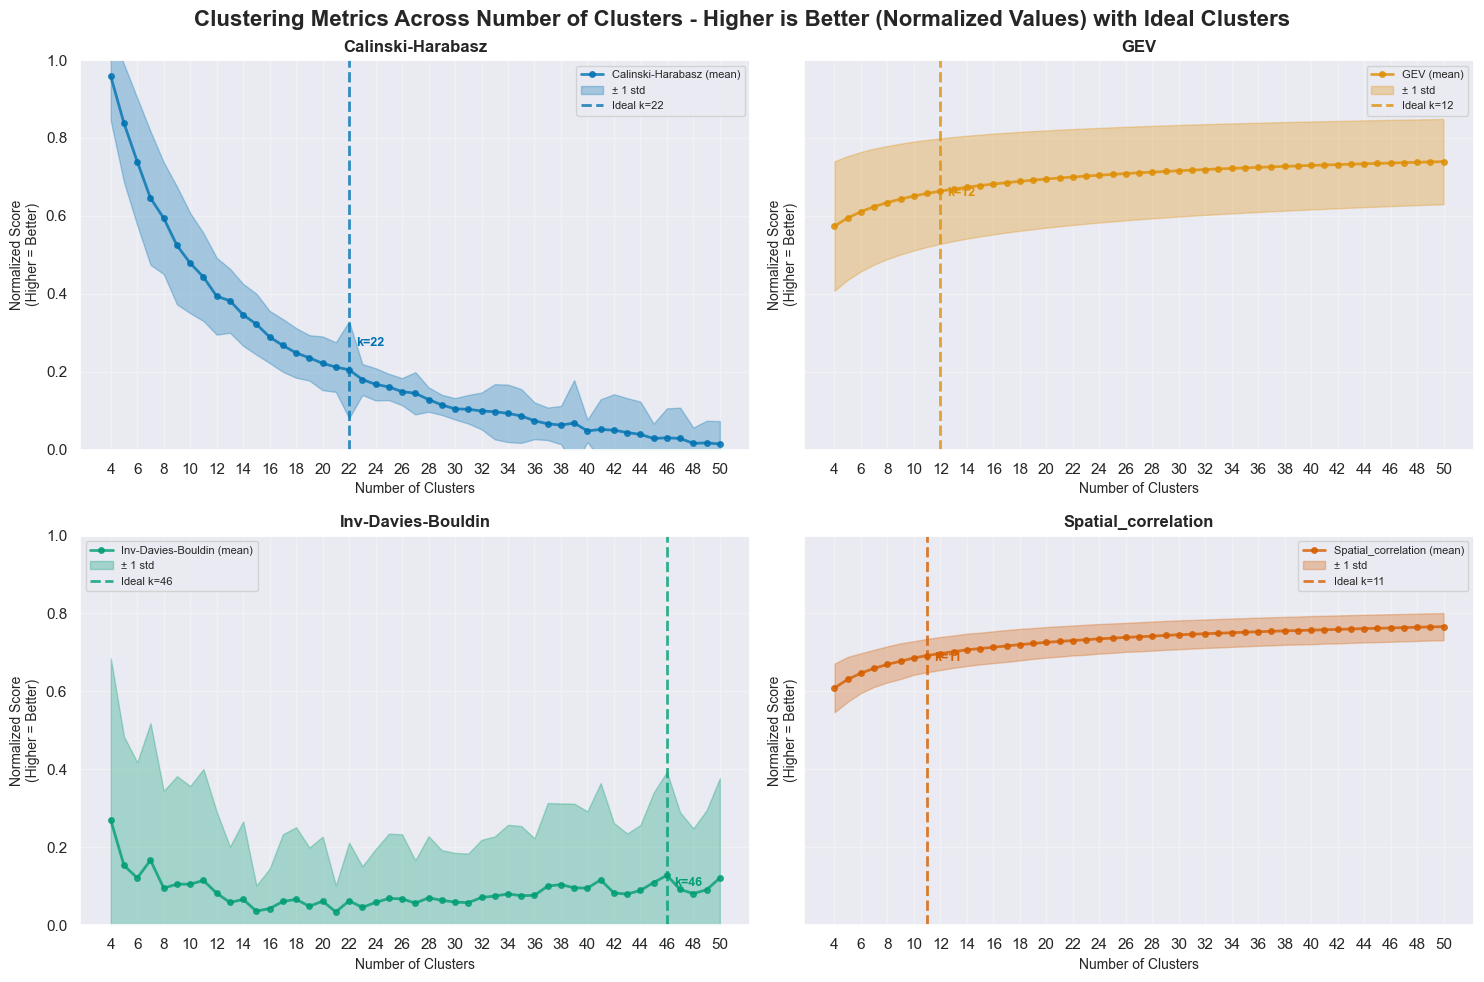

In [101]:
fig, axes = plot_all_metrics_with_std(comparison_df, use_normalized=True)
plt.show()

Creating aggregated table using NORMALIZED metrics:
Metric columns found: ['GEV_normalized', 'Calinski-Harabasz_normalized', 'Davies-Bouldin_normalized', 'Inv-Davies-Bouldin_normalized', 'Spatial_correlation_normalized']
Metric names extracted: ['GEV', 'Calinski-Harabasz', 'Davies-Bouldin', 'Inv-Davies-Bouldin', 'Spatial_correlation']
Cluster numbers: [np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int6

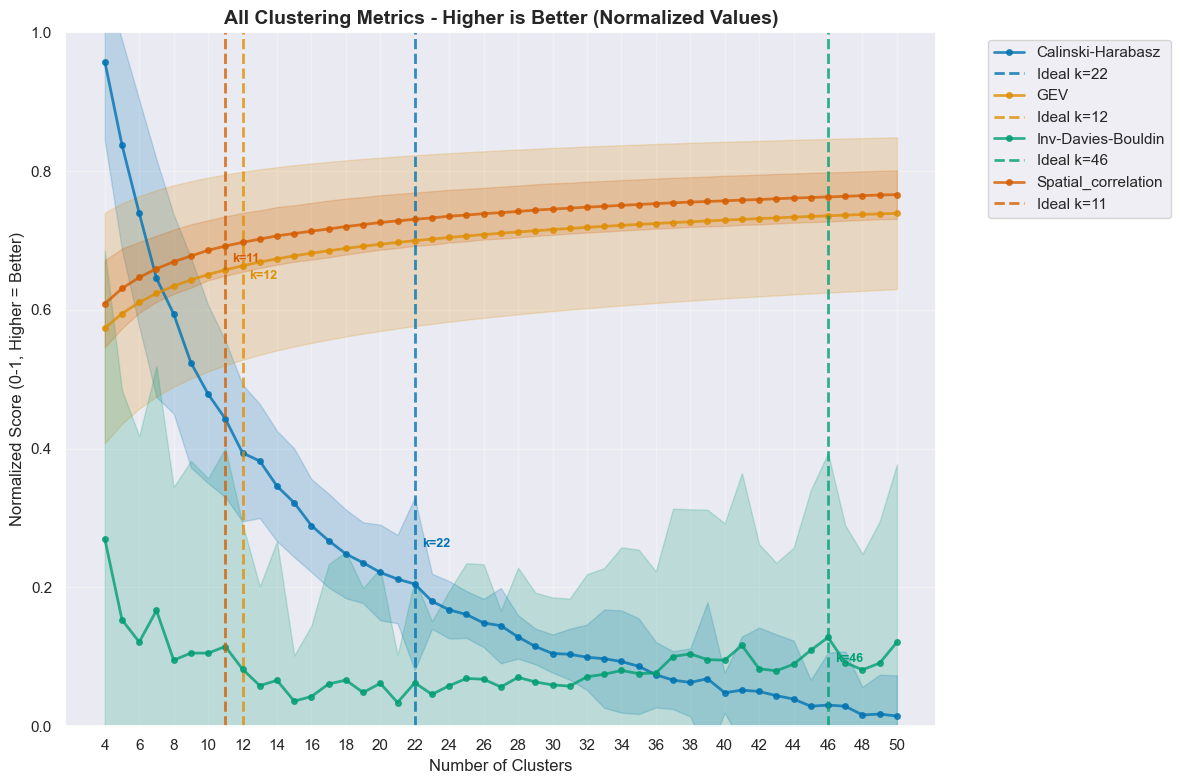

In [102]:
fig, ax = plot_all_metrics_single_plot(comparison_df, use_normalized=True)
plt.show()

### Violin plots
#### Functions

In [75]:
def plot_all_metrics_with_std(comparison_df, use_normalized=True, figsize=(15, 10), save_path=None):
    """
    Plot all metrics with standard deviation bands across cluster numbers in separate subplots.
    Davies-Bouldin metrics are automatically inverted by the aggregation function.
    Y-axis is shared and fixed from 0 to 1 for normalized data.
    
    Parameters:
    comparison_df: DataFrame with clustering results
    use_normalized: Whether to use normalized or original metrics
    figsize: Figure size (width, height)
    save_path: If provided, save the plot to this path
    
    Returns:
    fig, axes: matplotlib figure and axes objects
    """
    
    # Get aggregated data (Davies-Bouldin automatically inverted)
    agg_df = create_aggregated_metrics_table(comparison_df, use_normalized)
    
    # Extract metric names
    metric_names = list(set([col[:-5] for col in agg_df.columns if col.endswith('_mean')]))
    metric_names = sorted(metric_names)  # Sort for consistent ordering
    
    print(f"Plotting metrics: {metric_names}")
    
    # Set up the plot
    n_metrics = len(metric_names)
    n_cols = 2  # Two columns
    n_rows = (n_metrics + 1) // 2  # Calculate rows needed
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharey=use_normalized)
    
    # Handle case where we have only one row
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Flatten axes for easier indexing
    axes_flat = axes.flatten()
    
    # Color palette
    colors = plt.cm.Set1(np.linspace(0, 1, n_metrics))
    
    # Plot each metric
    for i, metric in enumerate(metric_names):
        ax = axes_flat[i]
        
        # Get data
        cluster_numbers = agg_df.index
        means = agg_df[f'{metric}_mean']
        stds = agg_df[f'{metric}_std']
        
        # Plot mean line
        ax.plot(cluster_numbers, means, 'o-', color=colors[i], linewidth=2, 
                markersize=4, label=f'{metric} (mean)', alpha=0.8)
        
        # Plot standard deviation band
        ax.fill_between(cluster_numbers, means - stds, means + stds, 
                       color=colors[i], alpha=0.3, label=f'± 1 std')
        
        # Formatting
        ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Number of Clusters', fontsize=10)
        
        # Set y-label and limits based on metric type
        if use_normalized:
            ax.set_ylabel('Normalized Score\n(Higher = Better)', fontsize=10)
            ax.set_ylim(0, 1)  # Fix limits from 0 to 1
        else:
            ax.set_ylabel('Original Score\n(Higher = Better)', fontsize=10)
            ax.set_ylim(bottom=0)  # Start from 0, auto-scale top
        
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        
        # Set x-axis to show only integer values
        ax.set_xticks(cluster_numbers[::2])  # Show every other tick to avoid crowding
    
    # Hide unused subplots
    for j in range(n_metrics, len(axes_flat)):
        axes_flat[j].set_visible(False)
    
    # Overall title
    title_type = "Normalized" if use_normalized else "Original"
    fig.suptitle(f'Clustering Metrics Across Number of Clusters - Higher is Better ({title_type} Values)', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    return fig, axes

def plot_all_metrics_single_plot(comparison_df, use_normalized=True, figsize=(12, 8), save_path=None):
    """
    Plot all metrics in a single plot with consistent "higher is better" direction.
    Davies-Bouldin metrics are automatically inverted by the aggregation function.
    Y-axis is shared and fixed from 0 to 1 for normalized data.
    
    Parameters:
    comparison_df: DataFrame with clustering results
    use_normalized: Whether to use normalized or original metrics
    figsize: Figure size (width, height)
    save_path: If provided, save the plot to this path
    """
    
    # Get aggregated data (Davies-Bouldin automatically inverted)
    agg_df = create_aggregated_metrics_table(comparison_df, use_normalized)
    
    # Extract metric names
    metric_names = list(set([col[:-5] for col in agg_df.columns if col.endswith('_mean')]))
    metric_names = sorted(metric_names)
    
    print(f"Plotting metrics: {metric_names}")
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Color palette
    colors = plt.cm.Set1(np.linspace(0, 1, len(metric_names)))
    
    cluster_numbers = agg_df.index
    
    # Plot each metric
    for i, metric in enumerate(metric_names):
        means = agg_df[f'{metric}_mean']
        stds = agg_df[f'{metric}_std']
        
        # Plot mean line
        line = ax.plot(cluster_numbers, means, 'o-', color=colors[i], 
                      linewidth=2, markersize=4, label=metric, alpha=0.8)
        
        # Plot standard deviation band
        ax.fill_between(cluster_numbers, means - stds, means + stds, 
                       color=colors[i], alpha=0.2)
    
    # Formatting
    title_type = "Normalized" if use_normalized else "Original"
    ax.set_title(f'All Clustering Metrics - Higher is Better ({title_type} Values)', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Number of Clusters', fontsize=12)
    
    if use_normalized:
        ax.set_ylabel('Normalized Score (0-1, Higher = Better)', fontsize=12)
        # Fix y-axis limits from 0 to 1 for normalized data
        ax.set_ylim(0, 1)
    else:
        ax.set_ylabel('Metric Value (Higher = Better)', fontsize=12)
        # For original data, let matplotlib auto-scale but ensure it starts from 0
        ax.set_ylim(bottom=0)
    
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set x-axis to show reasonable number of ticks
    ax.set_xticks(cluster_numbers[::2])
    
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    return fig, ax

def plot_metrics_violin(comparison_df, use_normalized=True, figsize=(20, 12), save_path=None):
    """
    Create violin plots showing the distribution of each metric across subjects for each cluster number.
    Davies-Bouldin metrics are automatically inverted by the aggregation function.
    
    Parameters:
    comparison_df: DataFrame with clustering results
    use_normalized: Whether to use normalized or original metrics
    figsize: Figure size (width, height)
    save_path: If provided, save the plot to this path
    
    Returns:
    fig, axes: matplotlib figure and axes objects
    """
    
    # Handle Davies-Bouldin inversion in the dataframe
    df_to_plot = comparison_df.copy()
    
    # Determine which columns to use
    if use_normalized:
        metric_suffix = '_normalized'
        title_type = "Normalized"
    else:
        metric_suffix = '_original'
        title_type = "Original"
    
    # Find metric columns
    metric_columns = [col for col in df_to_plot.columns if col.endswith(metric_suffix)]
    metric_names = [col[:-len(metric_suffix)] for col in metric_columns]
    
    # Handle Davies-Bouldin inversion
    davies_metrics = [name for name in metric_names if 'Davies-Bouldin' in name and 'Inv' not in name]
    if davies_metrics:
        print(f"Inverting Davies-Bouldin metrics: {davies_metrics}")
        
        for metric_name in davies_metrics:
            original_col = f'{metric_name}_original'
            normalized_col = f'{metric_name}_normalized'
            
            if original_col in df_to_plot.columns:
                # Invert from original values
                original_values = df_to_plot[original_col]
                safe_values = np.where(original_values > 1e-10, original_values, 1e-10)
                inverted_original = 1.0 / safe_values
                
                # Normalize the inverted values within each subject
                inverted_normalized = []
                for subject_id in df_to_plot['subject_id'].unique():
                    subject_mask = df_to_plot['subject_id'] == subject_id
                    subject_inverted = inverted_original[subject_mask]
                    
                    min_val = subject_inverted.min()
                    max_val = subject_inverted.max()
                    if max_val > min_val:
                        subject_normalized = (subject_inverted - min_val) / (max_val - min_val)
                    else:
                        subject_normalized = np.zeros_like(subject_inverted)
                    
                    inverted_normalized.extend(subject_normalized)
                
                # Update dataframe
                new_metric_name = f'Inv-{metric_name}'
                df_to_plot[f'{new_metric_name}_original'] = inverted_original
                df_to_plot[f'{new_metric_name}_normalized'] = inverted_normalized
                
                # Remove original Davies-Bouldin
                df_to_plot = df_to_plot.drop(columns=[original_col, normalized_col])
    
    # Update metric columns after inversion
    metric_columns = [col for col in df_to_plot.columns if col.endswith(metric_suffix)]
    metric_names = [col[:-len(metric_suffix)] for col in metric_columns]
    
    print(f"Creating violin plots for metrics: {metric_names}")
    
    # Set up the plot
    n_metrics = len(metric_names)
    n_cols = 2
    n_rows = (n_metrics + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharey=use_normalized)
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    axes_flat = axes.flatten()
    
    # Use colorblind-friendly palette
    colors = sns.color_palette("colorblind", n_metrics)
    
    # Create violin plots for each metric
    for i, (metric_name, metric_col) in enumerate(zip(metric_names, metric_columns)):
        ax = axes_flat[i]
        
        # Prepare data for violin plot
        cluster_numbers = sorted(df_to_plot['cluster_number'].unique())
        plot_data = []
        positions = []
        
        for cluster_num in cluster_numbers:
            cluster_data = df_to_plot[df_to_plot['cluster_number'] == cluster_num][metric_col]
            plot_data.append(cluster_data.values)
            positions.append(cluster_num)
        
        # Create violin plot
        violin_parts = ax.violinplot(plot_data, positions=positions, widths=0.8, 
                                   showmeans=True, showmedians=True)
        
        # Customize violin appearance with colorblind-friendly colors
        for pc in violin_parts['bodies']:
            pc.set_facecolor(colors[i])
            pc.set_alpha(0.7)
        
        # Customize other elements
        violin_parts['cmeans'].set_color('red')
        violin_parts['cmeans'].set_linewidth(2)
        violin_parts['cmedians'].set_color('black')
        violin_parts['cmedians'].set_linewidth(1)
        
        # Add mean line connecting all means
        means = [np.mean(data) for data in plot_data]
        ax.plot(positions, means, 'r-', linewidth=2, alpha=0.8, label='Mean')
        
        # Formatting
        ax.set_title(f'{metric_name}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Number of Clusters', fontsize=12)
        
        if use_normalized:
            ax.set_ylabel('Normalized Score\n(Higher = Better)', fontsize=12)
            ax.set_ylim(0, 1)
        else:
            ax.set_ylabel('Original Score\n(Higher = Better)', fontsize=12)
            ax.set_ylim(bottom=0)
        
        ax.grid(True, alpha=0.3)
        ax.set_xticks(positions[::2])  # Show every other tick
        
        # Add legend for first subplot
        if i == 0:
            ax.legend(['Mean trend'], loc='upper left')
    
    # Hide unused subplots
    for j in range(n_metrics, len(axes_flat)):
        axes_flat[j].set_visible(False)
    
    # Overall title
    fig.suptitle(f'Distribution of Clustering Metrics Across Subjects - Higher is Better ({title_type} Values)', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Violin plot saved to: {save_path}")
    
    return fig, axes

def plot_single_metric_violin(comparison_df, metric_name, use_normalized=True, 
                             figsize=(15, 6), save_path=None):
    """
    Create a detailed violin plot for a single metric across all cluster numbers.
    
    Parameters:
    comparison_df: DataFrame with clustering results
    metric_name: Name of the metric to plot (e.g., 'GEV', 'Calinski-Harabasz')
    use_normalized: Whether to use normalized or original metrics
    figsize: Figure size (width, height)
    save_path: If provided, save the plot to this path
    """
    
    # Handle Davies-Bouldin inversion if needed
    df_to_plot = comparison_df.copy()
    
    if 'Davies-Bouldin' in metric_name and 'Inv' not in metric_name:
        # Need to invert this metric
        original_col = f'{metric_name}_original'
        if original_col in df_to_plot.columns:
            original_values = df_to_plot[original_col]
            safe_values = np.where(original_values > 1e-10, original_values, 1e-10)
            inverted_original = 1.0 / safe_values
            
            # Normalize within each subject
            inverted_normalized = []
            for subject_id in df_to_plot['subject_id'].unique():
                subject_mask = df_to_plot['subject_id'] == subject_id
                subject_inverted = inverted_original[subject_mask]
                
                min_val = subject_inverted.min()
                max_val = subject_inverted.max()
                if max_val > min_val:
                    subject_normalized = (subject_inverted - min_val) / (max_val - min_val)
                else:
                    subject_normalized = np.zeros_like(subject_inverted)
                
                inverted_normalized.extend(subject_normalized)
            
            metric_name = f'Inv-{metric_name}'
            df_to_plot[f'{metric_name}_original'] = inverted_original
            df_to_plot[f'{metric_name}_normalized'] = inverted_normalized
    
    # Determine column to use
    if use_normalized:
        metric_col = f'{metric_name}_normalized'
        title_type = "Normalized"
    else:
        metric_col = f'{metric_name}_original'
        title_type = "Original"
    
    if metric_col not in df_to_plot.columns:
        print(f"Error: Column '{metric_col}' not found!")
        return None, None
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Prepare data
    cluster_numbers = sorted(df_to_plot['cluster_number'].unique())
    plot_data = []
    positions = []
    
    for cluster_num in cluster_numbers:
        cluster_data = df_to_plot[df_to_plot['cluster_number'] == cluster_num][metric_col]
        plot_data.append(cluster_data.values)
        positions.append(cluster_num)
    
    # Use colorblind-friendly color (first color from the palette)
    violin_color = sns.color_palette("colorblind", 1)[0]
    
    # Create violin plot
    violin_parts = ax.violinplot(plot_data, positions=positions, widths=0.8, 
                               showmeans=True, showmedians=True, showextrema=True)
    
    # Customize appearance with colorblind-friendly color
    for pc in violin_parts['bodies']:
        pc.set_facecolor(violin_color)
        pc.set_alpha(0.7)
        pc.set_edgecolor('navy')
    
    violin_parts['cmeans'].set_color('red')
    violin_parts['cmeans'].set_linewidth(2)
    violin_parts['cmedians'].set_color('black') 
    violin_parts['cmedians'].set_linewidth(1.5)
    
    # Add mean and std lines
    means = [np.mean(data) for data in plot_data]
    stds = [np.std(data) for data in plot_data]
    
    ax.plot(positions, means, 'ro-', linewidth=2, markersize=4, label='Mean', alpha=0.8)
    ax.fill_between(positions, 
                   [m - s for m, s in zip(means, stds)], 
                   [m + s for m, s in zip(means, stds)], 
                   alpha=0.2, color='red', label='±1 std')
    
    # Formatting
    ax.set_title(f'{metric_name} Distribution Across Subjects ({title_type})', 
                fontsize=16, fontweight='bold')
    ax.set_xlabel('Number of Clusters', fontsize=14)
    
    if use_normalized:
        ax.set_ylabel('Normalized Score (Higher = Better)', fontsize=14)
        ax.set_ylim(0, 1)
    else:
        ax.set_ylabel('Original Score (Higher = Better)', fontsize=14)
        ax.set_ylim(bottom=0)
    
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_xticks(positions[::2])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Single metric violin plot saved to: {save_path}")
    
    return fig, ax

#### Plots

Inverting Davies-Bouldin metrics: ['Davies-Bouldin']
Creating violin plots for metrics: ['GEV', 'Calinski-Harabasz', 'Inv-Davies-Bouldin', 'Spatial_correlation']


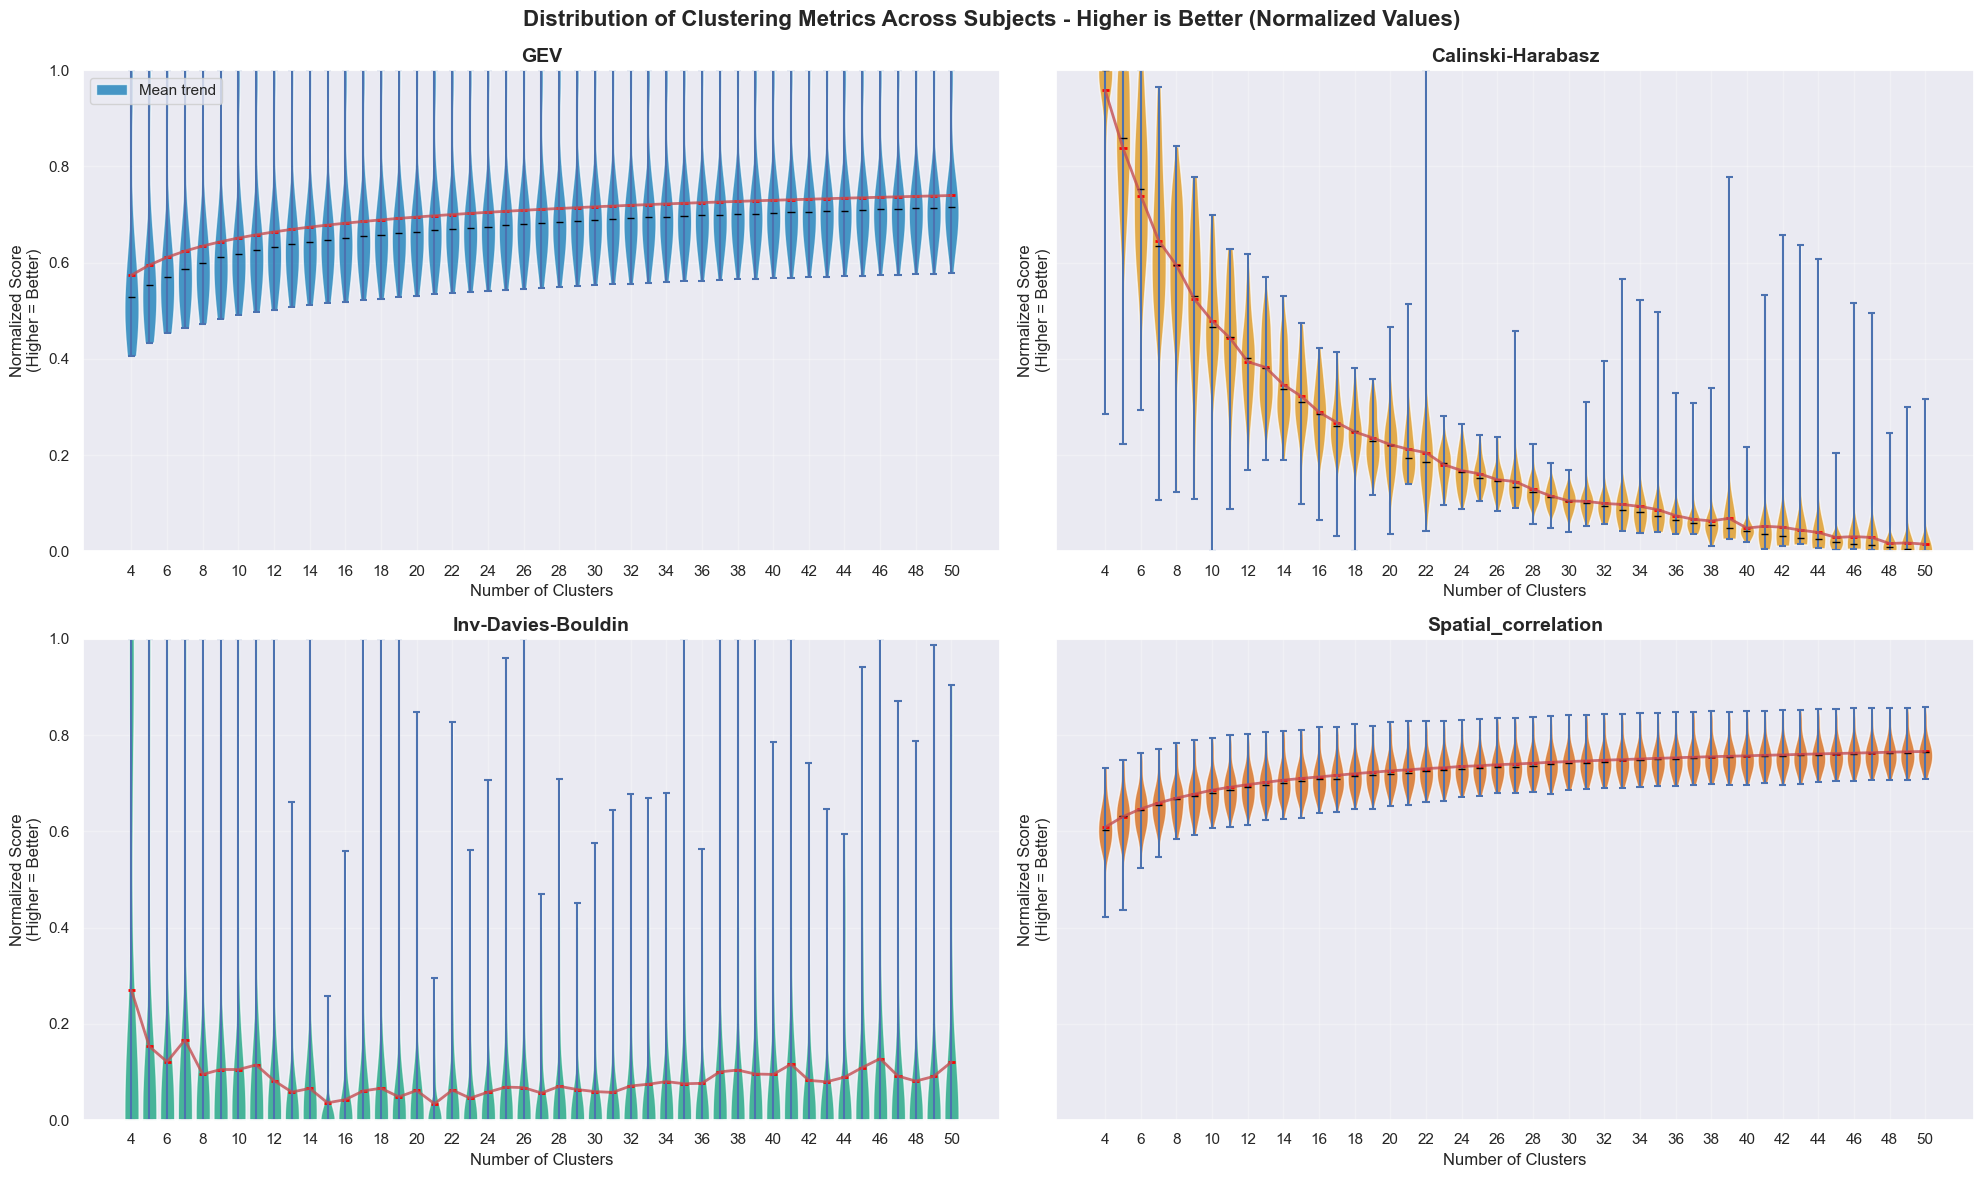

In [76]:
fig, axes = plot_metrics_violin(comparison_df, use_normalized=True)
plt.show()

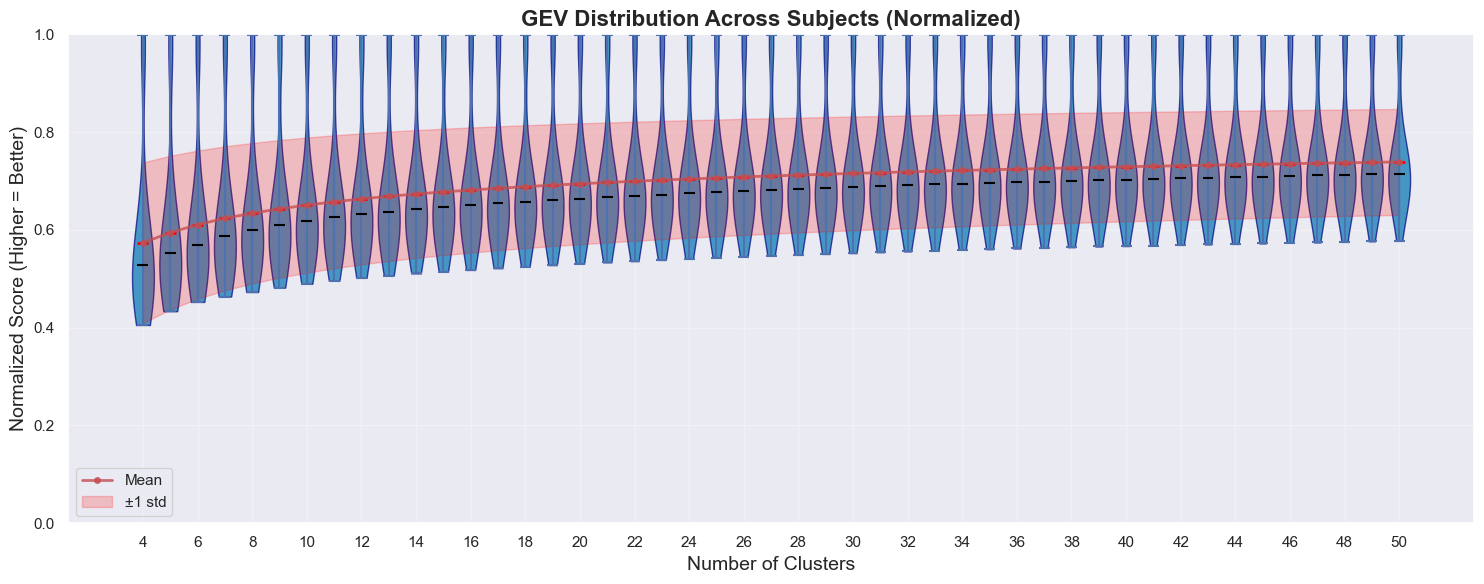

In [77]:
fig, ax = plot_single_metric_violin(comparison_df, 'GEV', use_normalized=True)
plt.show()